# Generador de caras de anime con DCGAN
- Ricardo Damián Hernández Ramírez
- 740356
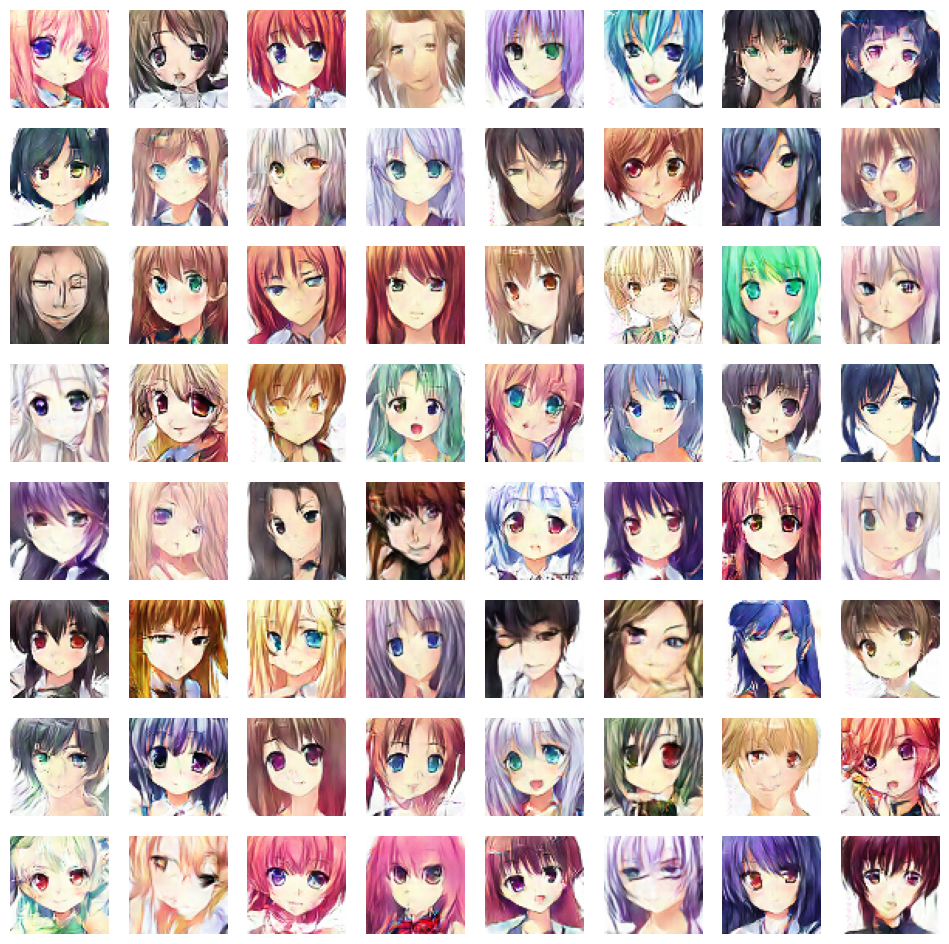

La creación de imágenes de anime es un campo en constante evolución que ha experimentado un gran interés en los últimos años, tanto por parte de entusiastas como de profesionales del diseño gráfico y la animación. La capacidad de generar caras nuevas de anime de manera realista y convincente es un desafío complejo que requiere una combinación de creatividad artística y avances tecnológicos en el campo del aprendizaje profundo.

Este proyecto se centra en utilizar una Deep Convolutional Generative Adversarial Network (DCGAN), una arquitectura de red neuronal especialmente diseñada para la generación de imágenes realistas. La elección de una DCGAN se debe a su capacidad para capturar las características de alta resolución y las estructuras de las imágenes, lo que la hace ideal para la generación de caras de anime detalladas y convincentes.

Utilizando un conjunto de datos de imágenes de anime de alta calidad, nuestro objetivo es entrenar la DCGAN para que aprenda las características distintivas del estilo de dibujo de anime y genere imágenes que sean coherentes y estéticamente agradables. El anime muestra una gran diversidad de estilos y expresiones artísticas, lo que ofrece un amplio terreno para explorar las capacidades creativas de las DCGAN.

Crear un modelo capaz de generar caras de anime nuevas y únicas no solo representa un avance tecnológico, sino también una contribución al enriquecimiento del vasto universo del anime. Esta herramienta creativa tiene el potencial de inspirar a artistas y ampliar las fronteras de la imaginación en este campo del arte visual. La elección de una DCGAN nos permite abordar este desafío de manera efectiva, aprovechando su capacidad para capturar la complejidad y la belleza del arte del anime en cada imagen generada.

## Librerías

In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import LeakyReLU , ReLU, PReLU
from tensorflow.keras.layers import Conv2D ,Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt


## Dataset
Este es un conjunto de datos que consta de 21551 caras de anime extraídas de www.getchu.com, que luego se recortan utilizando el algoritmo de detección de caras de anime en https://github.com/nagadomi/lbpcascade_animeface. Todas las imágenes se cambiaron a un tamaño de 64 * 64 por conveniencia. Este dataset está disponible en [Kaggle](https://www.kaggle.com/datasets/soumikrakshit/anime-faces).

In [2]:
#kaggle api
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
from google.colab import files
files.upload();

Saving kaggle.json to kaggle.json


In [5]:
! cp kaggle.json ~/.kaggle/
! rm -f kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d soumikrakshit/anime-faces

 96% 425M/441M [00:05<00:00, 60.1MB/s]
100% 441M/441M [00:05<00:00, 86.7MB/s]


In [8]:
!unzip anime-faces.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: data/data/5499.png      
  inflating: data/data/55.png        
  inflating: data/data/550.png       
  inflating: data/data/5500.png      
  inflating: data/data/5501.png      
  inflating: data/data/5502.png      
  inflating: data/data/5503.png      
  inflating: data/data/5504.png      
  inflating: data/data/5505.png      
  inflating: data/data/5506.png      
  inflating: data/data/5507.png      
  inflating: data/data/5508.png      
  inflating: data/data/5509.png      
  inflating: data/data/551.png       
  inflating: data/data/5510.png      
  inflating: data/data/5511.png      
  inflating: data/data/5512.png      
  inflating: data/data/5513.png      
  inflating: data/data/5514.png      
  inflating: data/data/5515.png      
  inflating: data/data/5516.png      
  inflating: data/data/5517.png      
  inflating: data/data/5518.png      
  inflating: data/data/5519.png      
  inflating: data/dat

In [ ]:
!ls

anime-faces.zip  data  sample_data


## Carga del dataset

In [9]:
data_path = "data"


In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    label_mode=None,
    color_mode='rgb',
    batch_size=128,
    image_size=(64, 64),
    shuffle=True
)

train_ds = train_ds.map(lambda x: ((x/127.5)-1))

Found 43102 files belonging to 1 classes.


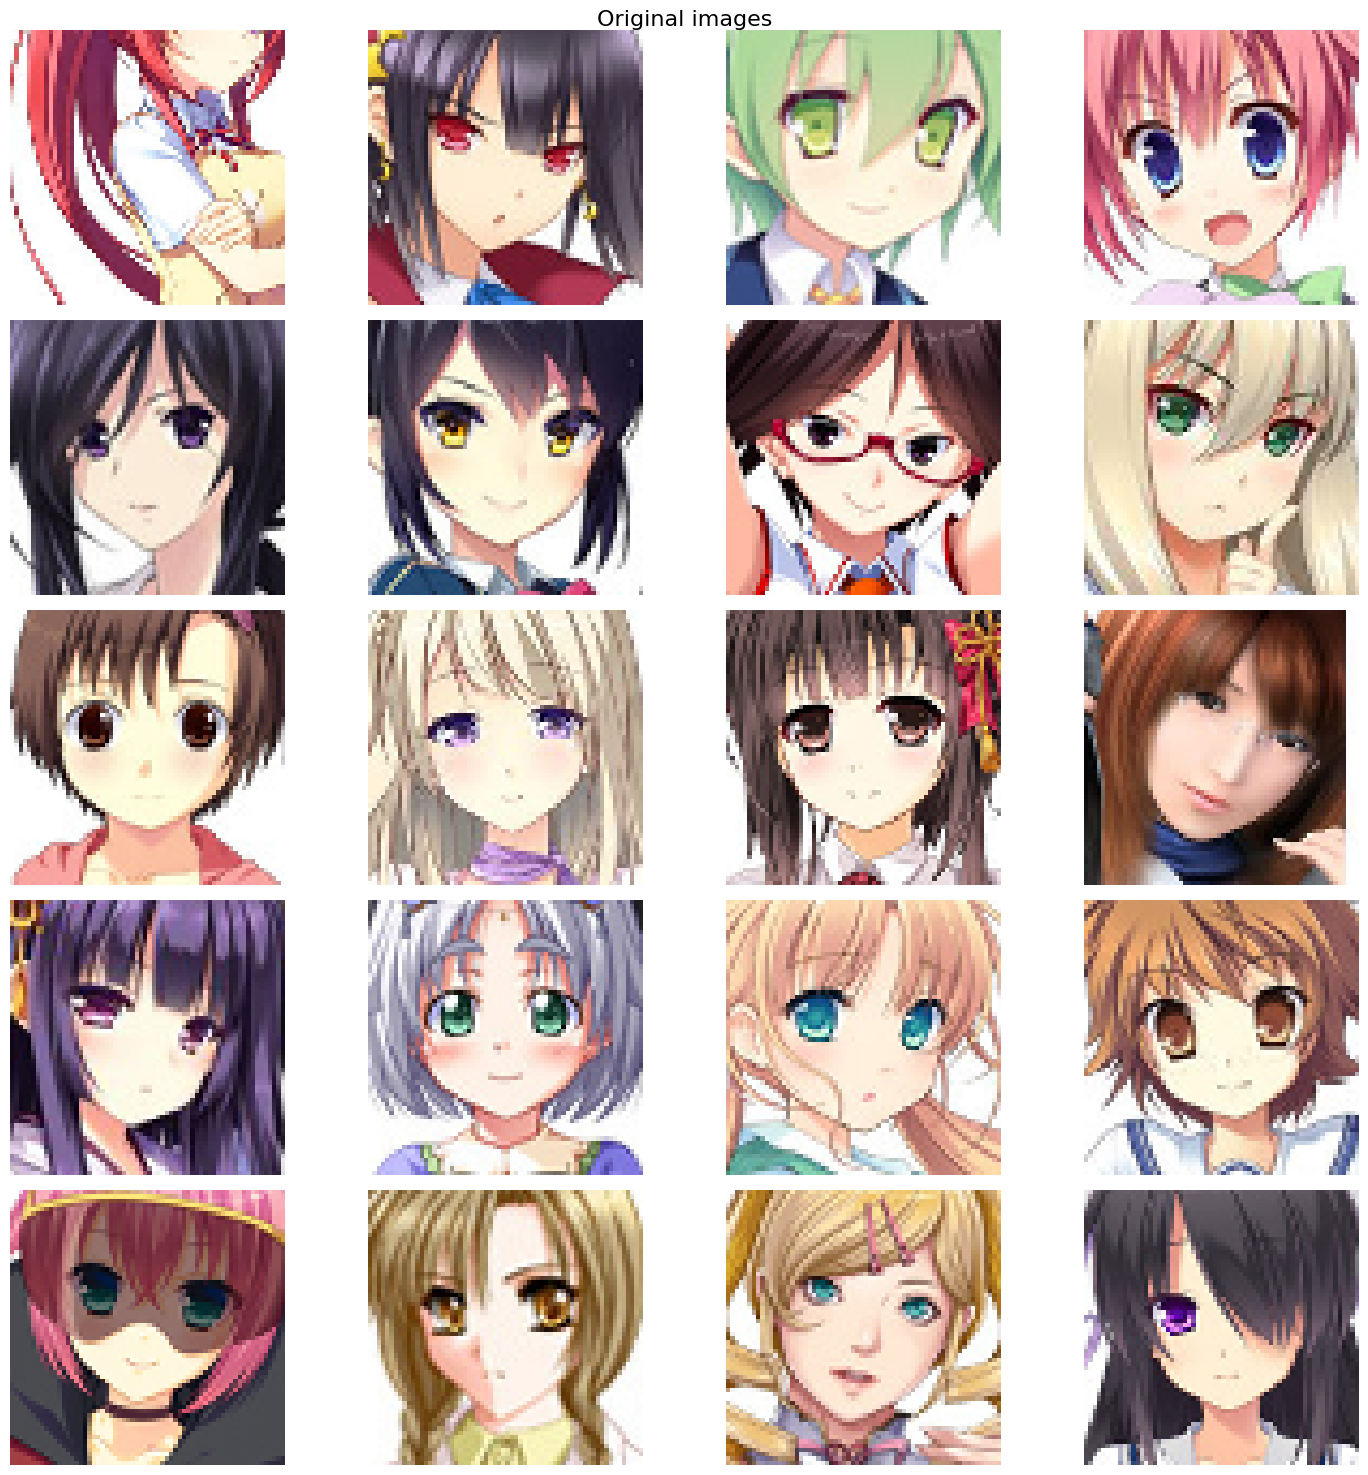

In [32]:
# Graficar algunas imagenes del conjunto de datos original
plt.figure(figsize=(15, 15))
plt.suptitle("Original images", fontsize=16)

for images in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)  
        plt.imshow((images[i] + 1) / 2)
        plt.axis('off')

plt.tight_layout()
plt.show()


## DCGan
La arquitectura se encuentra inspirada en el paper original de DCGAN, así como en parte del siguiente modeo  de Keras: 
https://keras.io/examples/generative/dcgan_overriding_train_step/

# Modelo DCGAN

Este es un modelo de Generative Adversarial Network (GAN) que utiliza la arquitectura Deep Convolutional GAN (DCGAN). Los GAN son un tipo de red neuronal utilizada para generar datos nuevos, como imágenes, que son similares a un conjunto de datos de entrada.

## Generador

El generador toma una semilla aleatoria como entrada y produce una imagen de tamaño deseado. Aquí está su arquitectura:

1. Capa Dense: Toma la semilla aleatoria y la proyecta a un tensor denso.
2. Capas de Batch Normalization: Normaliza los datos para acelerar el entrenamiento.
3. Capas de ReLU: Introduce no linealidades en la red.
4. Capas de Conv2DTranspose: Transforma el tensor denso en una imagen de mayor resolución.
5. Capa de Activación Tanh: Ajusta los valores de los píxeles de la imagen generada para que estén dentro del rango [-1, 1].

## Discriminador

El discriminador toma una imagen como entrada y predice si es real o falsa. Aquí está su arquitectura:

1. Capas de Conv2D: Procesan la imagen de entrada y extraen características.
2. Capas de Batch Normalization: Normalizan los datos para mejorar la estabilidad del entrenamiento.
3. Capas de LeakyReLU: Introducen no linealidades y evitan el problema del desvanecimiento del gradiente.
4. Capas de Flatten: Aplanan el tensor para que pueda ser procesado por capas densas.
5. Capa de Activación Sigmoid: Produce una salida entre 0 y 1, indicando la probabilidad de que la imagen sea real.

## Entrenamiento

Durante el entrenamiento, el generador y el discriminador se entrenan de manera adversarial. El generador intenta engañar al discriminador generando imágenes que parezcan reales, mientras que el discriminador intenta distinguir entre imágenes reales y generadas. El proceso es el siguiente:

1. El generador genera imágenes a partir de semillas aleatorias.
2. El discriminador clasifica tanto imágenes reales como generadas como "reales" o "falsas".
3. Se calculan las pérdidas del generador y del discriminador.
4. Se calculan los gradientes y se aplican actualizaciones a los pesos de ambos modelos utilizando optimizadores específicos para cada uno.
5. Este proceso se repite durante varias iteraciones de entrenamiento.

## Funciones de pérdidas
1. **Pérdida del generador**: Se calcula utilizando la función de pérdida de entropía cruzada binaria entre la salida falsa del discriminador y un vector de unos.
2. **Pérdida del discriminador**: Se calcula utilizando la función de pérdida de entropía cruzada binaria entre la salida real y falsa del discriminador y vectores de unos y ceros, respectivamente.


## Compilación y Entrenamiento Personalizado

El modelo se compila con optimizadores para el generador y el discriminador. La función `train_step` realiza un paso de entrenamiento personalizado, calculando las pérdidas y aplicando las actualizaciones de pesos para ambos modelos.

Este modelo puede ser entrenado para generar imágenes sintéticas que sean visualmente similares a un conjunto de datos de imágenes de entrada.



In [11]:
init = tf.keras.initializers.RandomNormal(stddev=0.02)


In [12]:
def build_generator(seed_size):

    model = Sequential()
    model.add(Dense(4*4*1024,kernel_initializer=init,input_dim=seed_size))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Reshape((4,4,1024)))

    model.add(Conv2DTranspose(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) 

    model.add(Conv2DTranspose(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU()) 

    model.add(Conv2DTranspose(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv2DTranspose(3,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(Activation('tanh'))

    return model

In [13]:
def build_discriminator(image_length,image_channels):

    model = Sequential()
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',use_bias=False,input_shape=(image_length,image_length,image_channels),kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2)) 

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Conv2D(256,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(512,kernel_size=5,strides=2,padding='same',use_bias=False,kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Conv2D(1,kernel_size=4,strides=1,padding='valid',use_bias=False,kernel_initializer=init))
    model.add(Flatten())
    model.add(Activation('sigmoid'))

    return model

In [14]:
import tensorflow as tf
from tensorflow import keras

class DCGAN(keras.Model):

    def __init__(self, seed_size, image_length, image_channels, **kwargs):

        super(DCGAN, self).__init__(**kwargs)
        self.generator = build_generator(seed_size)
        self.discriminator = build_discriminator(image_length, image_channels)
        self.seed_size = seed_size
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy()

    def generator_loss(self, fake_output):

        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output, smooth=0.1):

        real_loss = self.cross_entropy(tf.ones_like(real_output) * (1 - smooth), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        return real_loss + fake_loss

    def compile(self, generator_optimizer, discriminator_optimizer):

        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    @tf.function
    def train_step(self, data):

        batch_size = tf.shape(data)[0]
        seed = tf.random.normal(shape=(batch_size, self.seed_size))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_image = self.generator(seed, training=True)
            real_output = self.discriminator(data, training=True)
            fake_output = self.discriminator(generated_image, training=True)
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {
            "generator_loss": gen_loss,
            "discriminator_loss": disc_loss
        }


In [15]:
#hiperparametros
image_length = 64
image_channels = 3
batch_size = 128
seed_size = 128


In [16]:
generator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)
discriminator_optimizer = Adam(learning_rate=0.0002,beta_1=0.5)

dcgan = DCGAN(seed_size,image_length,image_channels)
dcgan.compile(generator_optimizer,discriminator_optimizer)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [17]:

with tf.device('/GPU:0'):
    history = dcgan.fit(train_ds,epochs=80,batch_size=batch_size)

Epoch 1/80
337/337 [==============================] - 132s 348ms/step - generator loss: 4.8459 - discriminator_loss: 1.2548
Epoch 2/80
337/337 [==============================] - 117s 345ms/step - generator loss: 2.0945 - discriminator_loss: 0.9837
Epoch 3/80
337/337 [==============================] - 117s 347ms/step - generator loss: 2.0689 - discriminator_loss: 1.0251
Epoch 4/80
337/337 [==============================] - 116s 345ms/step - generator loss: 1.9359 - discriminator_loss: 0.9999
Epoch 5/80
337/337 [==============================] - 117s 346ms/step - generator loss: 2.0838 - discriminator_loss: 0.9484
Epoch 6/80
337/337 [==============================] - 116s 344ms/step - generator loss: 2.3506 - discriminator_loss: 0.8474
Epoch 7/80
337/337 [==============================] - 117s 347ms/step - generator loss: 2.4688 - discriminator_loss: 0.7969
Epoch 8/80
337/337 [==============================] - 116s 344ms/step - generator loss: 2.5065 - discriminator_loss: 0.7536
Epoch 9/

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:

save_path = "/content/drive/MyDrive/DCGAN"
dcgan.generator.save_weights(save_path + "generator_weights.h5")
dcgan.discriminator.save_weights(save_path + "discriminator_weights.h5")

## Generando imágenes nuevas

In [21]:
def generate_faces():
    noise = tf.random.normal([64,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

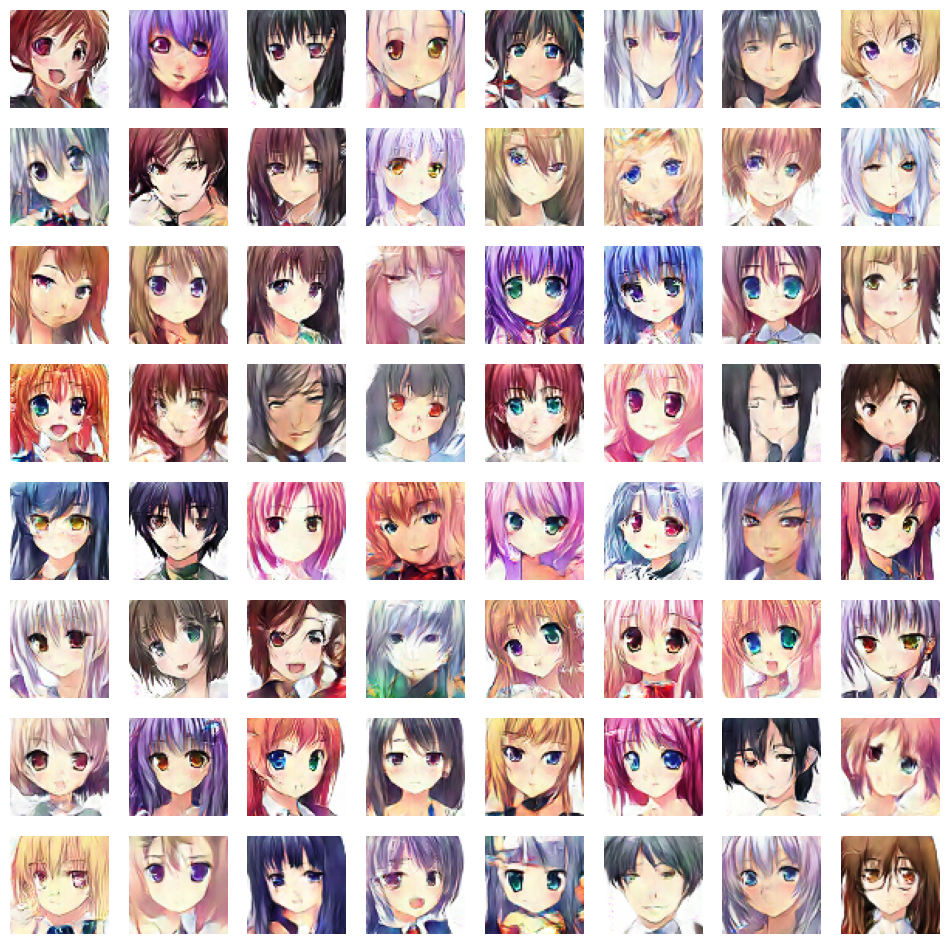

In [22]:
generate_faces()


In [23]:
dcgan.generator.load_weights("/content/drive/MyDrive/DCGANgenerator_weights.h5")
dcgan.discriminator.load_weights("/content/drive/MyDrive/DCGANdiscriminator_weights.h5")

In [24]:
def generate_faces():
    noise = tf.random.normal([64,seed_size])
    generated_images = dcgan.generator(noise)

    fig = plt.figure(figsize=(12,12))
    for i in range(generated_images.shape[0]):
        plt.subplot(8,8,i+1)
        plt.imshow((generated_images[i,:,:,:]*0.5+0.5))
        plt.axis("off")
    plt.show()

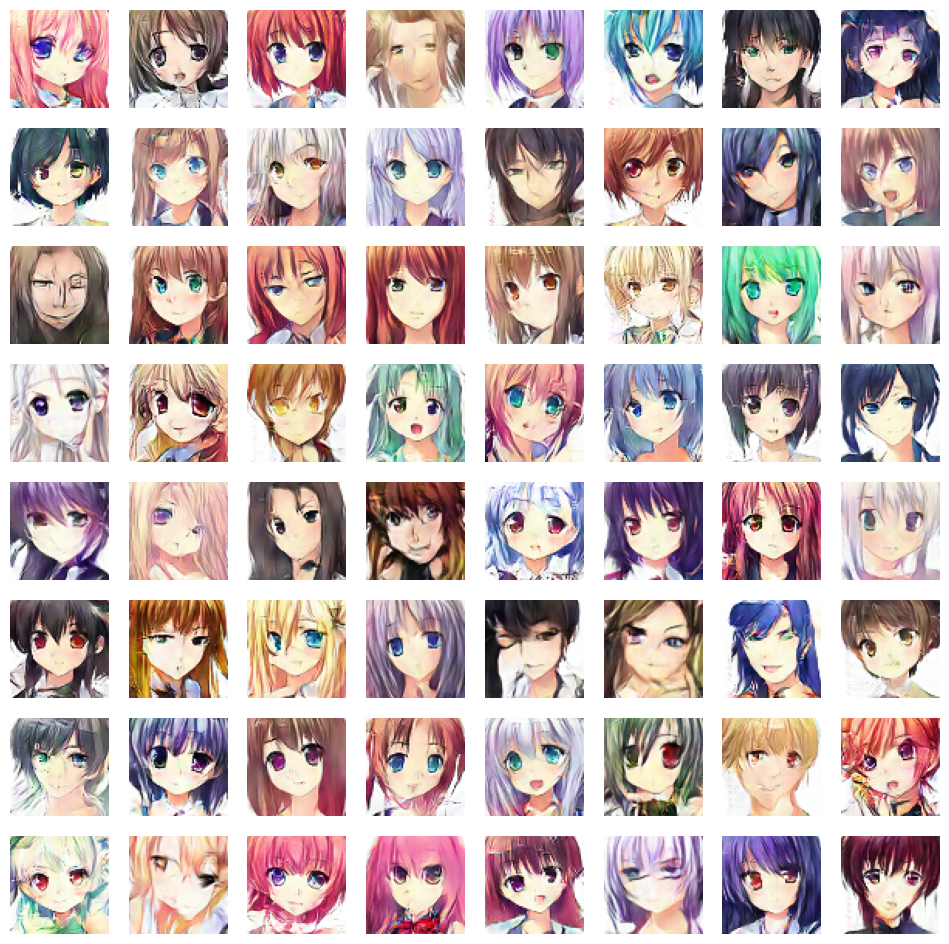

In [25]:
generate_faces()


## Resultados 

- Se generaron exitosamente **64 caras únicas** de personajes de anime.
- Las caras muestran una amplia **variedad en expresiones y estilos**, demostrando la capacidad de la GAN para capturar la esencia del diseño de personajes anime.
- Se observa una rica paleta de colores en el cabello de los personajes, incluyendo tonos como rosa, azul, verde y marrón.
- Los estilos de cabello varían desde cortes simples hasta peinados más elaborados y estilizados.
- A pesar de algunas imágenes parcialmente oscurecidas, la mayoría muestra una alta calidad y claridad en los detalles.
- Los ojos grandes y expresivos son consistentes con el estilo visual del anime y han sido reproducidos con precisión.

## Desafíos encontrados

- Inicialmente, se intentó implementar una StyleGAN para la generación de caras de personajes de anime. Sin embargo, durante el proceso de entrenamiento, se encontró que el tiempo requerido para entrenar la StyleGAN era considerablemente largo, por lo que tuve que limitar la cantidad de epocas para entrenar. Como resultado,la calidad de las imágenes generadas no alcanzó las expectativas iniciales. Los resultados fueron menos satisfactorios debido a la reducción en el número de épocas de entrenamiento.

- Ante estos desafíos, se decidió cambiar de estrategia y optar por implementar una Red Generativa Antagonista Profunda Convolutiva (DCGAN). La DCGAN demostró ser una alternativa más eficiente, mostrando un tiempo de entrenamiento significativamente menor. Con la DCGAN, se pudo aumentar el número de épocas de entrenamiento, lo que resultó en una mejora en la calidad de las imágenes generadas. Aunque la DCGAN puede no tener la misma capacidad de generar detalles finos como la StyleGAN, su eficiencia en términos de tiempo de entrenamiento y la calidad  de las imágenes generadas la convierten en una opción viable para este proyecto.



## Conclusión:
La GAN ha demostrado ser una herramienta eficaz para la generación de imágenes, en este caso caras de anime, ofreciendo una nueva vía para la exploración creativa en el diseño de personajes. Los resultados indican un potencial significativo para futuras aplicaciones y desarrollos en el campo de la inteligencia artificial y el arte generativo.

La elección de la arquitectura de la GAN puede tener un impacto significativo en el tiempo de entrenamiento y la calidad de los resultados. En este caso, la DCGAN resultó ser una opción más adecuada para la tarea